In [36]:
import csv
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

with open("IMDB top 1000.csv", encoding="utf-8") as f:
    reader = csv.reader(f)
    header = next(reader)   # ['', 'Title', 'Certificate', 'Duration', 'Genre', 'Rate', 'Metascore', 'Description', 'Cast', 'Info']
    rows = list(reader)

data = np.array(rows)

def to_int_safe(s):
    if not s: return math.nan
    s = s.replace(',', '').strip()
    try:
        return int(s)
    except:
        return math.nan

def to_float_safe(s):
    if not s: return math.nan
    s = s.strip().replace(',', '').replace('$','')
    try:
        if s.lower().endswith('m'):
            return float(s[:-1]) * 1_000_000
        if s.lower().endswith('k'):
            return float(s[:-1]) * 1_000
        return float(s)
    except:
        return math.nan

title_idx = header.index('Title')
genre_idx = header.index('Genre')
rate_idx  = header.index('Rate')
info_idx  = header.index('Info')

year_idx = header.index('Title')
released_years = np.array([int(row[title_idx].split("(")[-1].replace(")", "")) for row in data])

header.append("Released_Year")
data2 = np.column_stack((data, released_years))

year_idx_new = header.index('Released_Year')

year_avg = {}

for i in range(len(data2)):
    y = int(data2[i, year_idx_new])
    r = float(rates[i])

    if y not in year_avg:
        year_avg[y] = []
    year_avg[y].append(r)

In [37]:
years = data2[:, year_idx_new].astype(float)  # 문자열이면 float로 변환
rates = data[:, rate_idx].astype(float)

votes = []
gross = []

for row in data:
    info_str = row[info_idx]
    v_val, g_val = math.nan, math.nan
    if info_str:
        parts = [p.strip() for p in info_str.split("|")]
        for p in parts:
            if p.startswith("Votes:"):
                v_val = to_int_safe(p.replace("Votes:", "").strip())
            elif p.startswith("Gross:"):
                g_val = to_float_safe(p.replace("Gross:", "").strip())
    votes.append(v_val)
    gross.append(g_val)

votes = np.array(votes, dtype=float)
gross = np.array(gross, dtype=float)
decades = (years // 10) * 10  # 10년 단위 계산

def split_genres(cell):
    return [g.strip() for g in cell.split(',')] if cell else []

In [38]:
agg = defaultdict(lambda: {
    'count': 0,
    'rate_sum': 0.0, 'rate_n': 0,
    'votes_sum': 0.0, 'votes_n': 0,
    'gross_sum': 0.0, 'gross_n': 0,
    'pop_sum': 0.0, 'pop_n': 0  # popularity = gross/votes
})

for i in range(len(data2)):
    d = int((float(data2[i, year_idx_new]) // 10) * 10)  # data2의 Released_Year 사용
    r = rates[i]               # 관객 평점
    v = votes[i]               # 관객 수
    gval = gross[i]            # 흥행 수익

    for g in split_genres(data2[i, genre_idx]):
        key = (d, g)
        agg[key]['count'] += 1

        if not math.isnan(r):
            agg[key]['rate_sum'] += r
            agg[key]['rate_n'] += 1
        if not math.isnan(v):
            agg[key]['votes_sum'] += v
            agg[key]['votes_n'] += 1
        if not math.isnan(gval):
            agg[key]['gross_sum'] += gval
            agg[key]['gross_n'] += 1
        if not math.isnan(v) and not math.isnan(gval) and v > 0:
            agg[key]['pop_sum'] += gval / v
            agg[key]['pop_n'] += 1

count_by_decade_genre = defaultdict(dict)        # 10년 단위별 장르
rate_avg_by_decade_genre = defaultdict(dict)    # 10년 단위 장르별 평균 관객 평점
votes_avg_by_decade_genre = defaultdict(dict)   # 10년 단위 장르별 평균 관객 수
gross_avg_by_decade_genre = defaultdict(dict)   # 10년 단위 장르별 평균 흥행 수익
pop_avg_by_decade_genre = defaultdict(dict)     # 10년 단위 장르별 평균 흥행성

for (d, g), a in agg.items():
    count_by_decade_genre[d][g] = a['count']
    if a['rate_n']  > 0: rate_avg_by_decade_genre[d][g]  = round(a['rate_sum'] / a['rate_n'], 2)
    if a['votes_n'] > 0: votes_avg_by_decade_genre[d][g] = round(a['votes_sum'] / a['votes_n'], 2)
    if a['gross_n'] > 0: gross_avg_by_decade_genre[d][g] = round(a['gross_sum'] / a['gross_n'], 2)
    if a['pop_n']   > 0: pop_avg_by_decade_genre[d][g]   = round(a['pop_sum'] / a['pop_n'], 6)

In [44]:
df_count = pd.DataFrame(count_by_decade_genre).T 
df_count = df_count.fillna(0).astype(int)
df_count = df_count.sort_index() 
df_count = df_count[sorted(df_count.columns)]

df_rate = pd.DataFrame(rate_avg_by_decade_genre).T
df_rate = df_rate.fillna(0).round(2)
df_rate = df_rate.sort_index()
df_rate = df_rate[sorted(df_rate.columns)]

df_votes = pd.DataFrame(votes_avg_by_decade_genre).T
df_votes = df_votes.fillna(0).astype(int)
df_votes = df_votes.sort_index()
df_votes = df_votes[sorted(df_votes.columns)]

df_gross = pd.DataFrame(gross_avg_by_decade_genre).T
df_gross = df_gross.fillna(0).astype(int)
df_gross = df_gross.sort_index()
df_gross = df_gross[sorted(df_gross.columns)]

df_pop = pd.DataFrame(pop_avg_by_decade_genre).T
df_pop = df_pop.fillna(0).round(6)
df_pop = df_pop.sort_index()
df_pop = df_pop[sorted(df_pop.columns)]

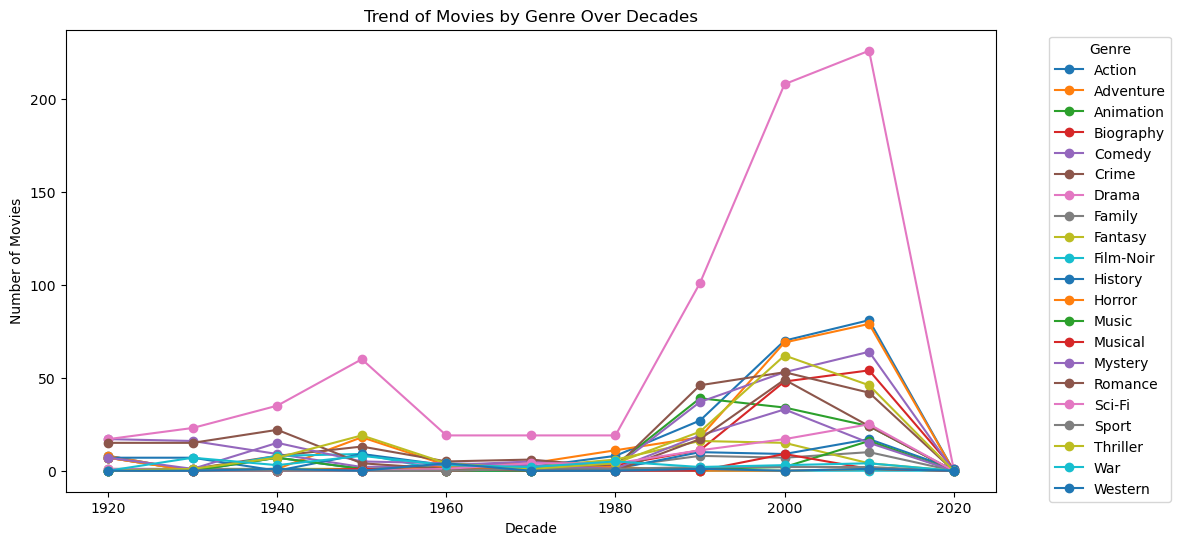

In [46]:
df_count.plot(kind='line', marker='o', figsize=(12,6))
plt.title("Trend of Movies by Genre Over Decades")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

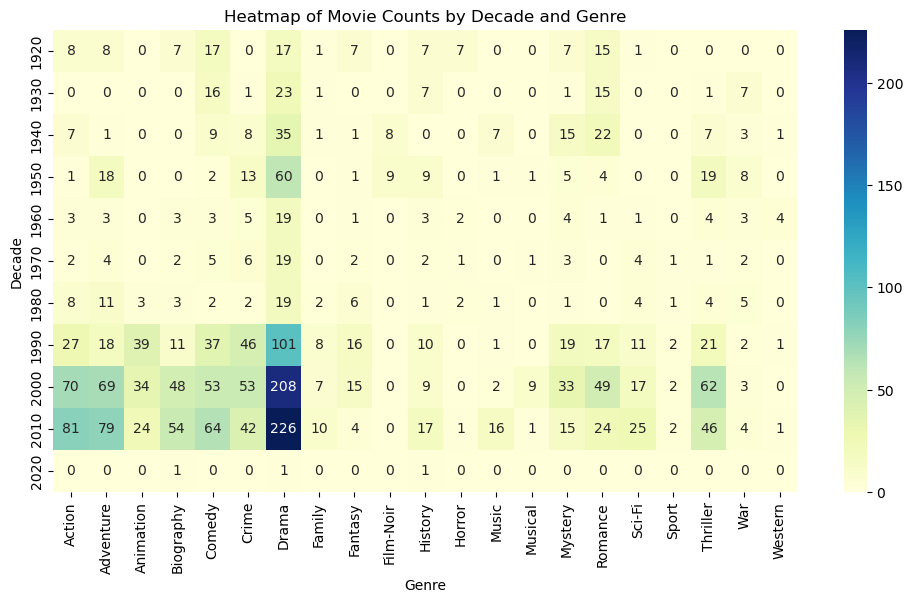

In [47]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(df_count, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Heatmap of Movie Counts by Decade and Genre")
plt.xlabel("Genre")
plt.ylabel("Decade")
plt.show()